# 

In [1]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_TSLA = '../bds/TSLA.csv'


In [2]:
TESLA = pd.read_csv(DATA_PATH_TSLA ,sep=',',usecols=[0,4])

In [3]:
TESLA

,Date,Close
0,2020-09-01,158.350006
1,2020-09-02,149.123337
2,2020-09-03,135.666672
3,2020-09-04,139.440002
4,2020-09-08,110.070000
...,...,...
1001,2024-08-26,213.210007
1002,2024-08-27,209.210007
1003,2024-08-28,205.750000
1004,2024-08-29,206.279999


significantLags: [1, 5, 8, 10]


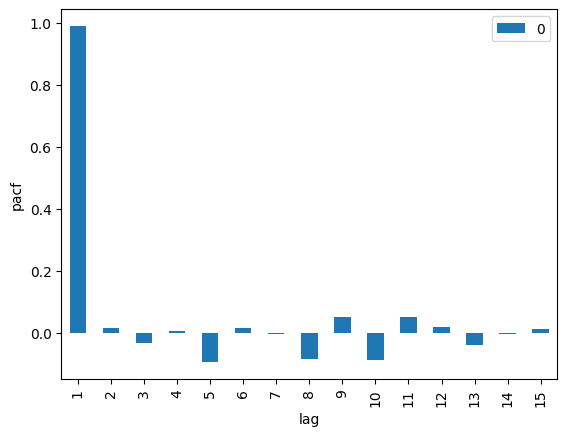

In [4]:
# acf, ci = sm.tsa.acf(endog, alpha=0.05)
def getSignificantLags(y, nLags = 5, alpha=0.05):
    pac, pac_ci = sm.tsa.pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(pac)[1:].plot(kind='bar', legend='pacf',
                               xlabel='lag', ylabel='pacf');
    significantLags = []
    for i in range(1, len(pac)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if pac[i] < pac_ci[i][0] - pac[i] or pac[i] > pac_ci[i][1] - pac[i]:
            significantLags.append(i)
    print('significantLags:', significantLags)
    return significantLags
e1_significantLags = getSignificantLags(y=TESLA['Close'], nLags = 15, alpha=0.05)

In [5]:
def appendLagVariables(yNm, significantLags, df, dropna=True):
    prefix = yNm.replace(')', '')
    df = df.copy()
    for lag in significantLags:
        varNm = '('+prefix+'-'+str(lag)+')'
        # nDj = pd.concat([nDj, nDj[['e1(t)']].shift(lag)], axis=1)
        df[varNm] = df[yNm].shift(lag)
        # nDj.columns = nDj.columns + [varNm]
    if dropna:
        df.dropna(axis=0, inplace=True)
    display(df.head(2))
    return df
TM_tesla = appendLagVariables(yNm='Close', 
                         significantLags = e1_significantLags, 
                         df = TESLA, 
                         dropna=True)

,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10)
10,2020-09-16,147.253326,149.919998,122.093330,135.666672,158.350006
11,2020-09-17,141.143326,147.253326,123.779999,139.440002,149.123337


In [6]:

df = TM_tesla.dropna()

# Separar features e target
X = df.drop('Close', axis=1)
X = X.drop('Date', axis=1)
y = df['Close']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

def calcular_metricas_regressao(y_true, y_pred):
    # Certifique-se de que y_true e y_pred são arrays de uma única dimensão
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()
    
    # Calcula as métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Raiz do MSE
    mape = tss.mape(y_true, y_pred)
    theil = tss.theil(y_true, y_pred)
    arv = tss.arv(y_true, y_pred)
    wpocid = tss.wpocid(y_true, y_pred)
    
    # Verifica se há mais de um ponto para calcular o R²
    if len(y_true) > 1:
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))  # Coeficiente de determinação
    else:
        r2 = 'N/A'  # Não aplicável para previsões de um único ponto
    
    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['MAE', 'MSE', 'MAPE','RMSE', 'R²','THEIL','ARV','WPOCID'],
        'Valor': [mae, mse, mape, rmse, r2, theil, arv, wpocid]
    })
    
    return metrics_df

# <center>FUNÇÕES BASEADAS EM KERNELS ONLINE</center>

## 1. PRELIMINARES

- O que é apredizado Online?

    São algoritmos de aprendizado de máquina que são projetados para aprender uma instânciade cada vez.
    
Estes modelos tem uma eficiência significativa, em seguida que o modelo retorna um resultado, o modelo receberá o valor verdadeiro que está associado ao resultado retornado a qual será útil para que o modelo ajuste os seus parâmetros.

- Como trabalhar com esses modelos quando estamos trabalhando com dados não lineares?

    Existem métodos chamados funções de kernels online que estendem os resultados para o aprendizado de dados não-lineares às metodologias de de aprendizado online.
    
    A ideia geral é transformar os dados, usando uma função, em dados que são linearmente separáveis.

    No contexto de aprendizado online, existem algoritmos que usam essa ideia, como o Online Kernel Perceptron ou o Online Support Vector Machine (SVM)


**PARA QUE SERVE O ESTUDO DESSE CONTEÚDO?**

O uso de funções kernel (especialmente em cenários online) tem como objetivo lidar com padrões não-lineares que surgem ao longo do tempo. Esses métodos são úteis quando o comportamento da série temporária não segue uma estrutura linear simples, e há necessidade de capturar relações mais complexas entre observações passadas e futuras.

**APLICAÇÕES NESTE TRABALHO**

Temos como objetivos nesse trabalho lidar com a série temporal dos valores de fechamento das ações da Tesla;

Teremos como objetivo geral fazer previsões de fechamento da série temporal da Tesla;

Um dos objetivos é realizar a implementação do algoritmo proposto do KRLS;

## 2. MÉTODOS USANDO KERNELS ONLINE

### 2.1 ESPAÇO DE CARACTERÍSTICAS (RKHS - Reproducing Kernel Hilbert Space)

Considere a função $\phi(x)$. Esta função será a transformação de dados não-lineares em dados lineramente separáveis, $\phi(x)$ basicamente transforma os dados não-lineares em um espaço de Hilbert (espaço de características [RKHS - Reproducing Kernel Hilbert Space]).

No **espaço de características** o produto interno poderá ser calculado por uma função $k( \bullet,\bullet)$ que satisfaz a condição de **Mercer's**:
$$k(x,\hat{x}) = \left< \phi(x),\phi(\hat{x})\right> $$

Onde $x\neq\hat{x}$

O espaço de características é importante pois com eles podemos adptar algoritmos lineares baseados em produtos interno em um algoritmo alternativo e não-lienar, bastanto substituir os produtos internos por $k( \bullet,\bullet)$.

**Exemplo:** A regressão linear baseada em kernels online, ou seja, no espaço de recursos, correspondde a uma solução do problema não-linear no espaço de entrada.



O aprendizado baseado em kernels online visa encontrar uma solução não linear $f:\chi\rightarrow\mathbb{R}$ que pode ser expessa como a expansão do kenel:

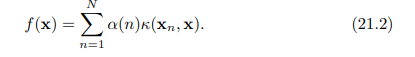 

Onde:

- $\alpha(n)$ : Coeficientes da expansão;

- N: Nº de dados;

- $x_n$: dados de treinamento, chamado na literatura de base.

Os métodos de kernels são técnicas não paramétricas, uma vez que não assumem um modelo especifico.

Um exemplo introdutório será dado através da abordagem para uma regressão baseada em kernels online, denominada de **Kernel Ridge Regression**.

### 2.2 Kernel Ridge Regression (KRR)

Suponha que tenhamos N dados de entrada $x_i$, $i=1,...,N$ e as suas saídas correspondentes a $y_i$ no espaço D-dimensional. Ou seja $x_i,y_i \in \mathbb{K}^{N\times D}$.

Para usar o método de Kernel Ridge Regression devemos construir uma matriz $X_{N\times D}$ com os dados de entradas empilhados.

Supondo $x_n = (x_{n,1},...,x_{n,D})$ onde $n= 1, ..., N$. Logo:

$$
X = \begin{pmatrix}
x_{1,1} & x_{1,2} & \cdots  & x_{1,D} \\
x_{2,1} & x_{2,2} & \cdots &  x_{2,D}\\
\vdots  & \vdots & \ddots  & \vdots \\
x_{N,1} & x_{N,2} & \cdots & x_{N,D} \\
\end{pmatrix}
$$

Na regressão linear, o problema de mínimos quadrados consiste em buscar um vetor $w \in \mathbb{R}^{D}$ talque:

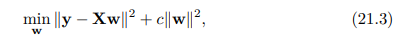

onde $c>0$ é a constante de regularização de Tikhonov. E a solução é dada por:

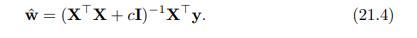


Quando $c=0$ a solução é bem definida apenas quando posto(X) é completo, ou seja, posto(X)=D.

Para onter a solução da equação **(21.4)** baseado em kernels online devemos inicialmente transformar os dados para o espaço de recursos, ou seja:

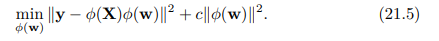

Onde:

- $\phi(X) = [\phi(x_1),...,\phi(x_N)]^T$

Logo, a solução do problema para $\phi(w)$ será dado por:

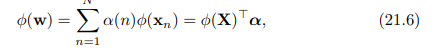

Onde:

- $\alpha = [\alpha(1),...,\alpha(N)]^T$

Agora, defina a matriz que será denominada de matriz de Kernel como:

$$K = \phi(X)\phi(X)^T$$

Onde temos que:
$$
k_{ij} = k(x_i,x_j)
$$

Substituindo a equação **(21.6)** em **(21.5)** vamos ter que:

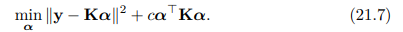

Portanto, a nossa solução será dada por:

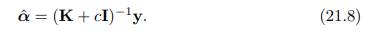

### 2.3 Dicionário de Aprendizado Online

O processo de aprendizado do dicionário tem como objetivo intentificar bases (dados de treinamento) que possam ser removidas ser ua perda significativa de desempenho.

Após a remoção dessas bases, a expanção aproximada do kernel é dada por:

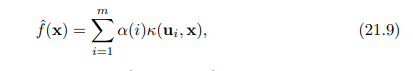

com $m<N$.

O dicionário $D = \{u_1, ..., u_m\}$ são vetores selecionados a partir de $x_n$ que são nossos dados de treinamento. Esses $u_i, i=1,...,m$ são escolhidos de maneira que possam representar todo o conjunto de dados.

A criação de dicionário na apredizado online segue duas etapas:

1) Inicialmente $D = \varnothing$

2) A medida que recebemos dados de treinamento fazemos a verificação: Se x segue uma determinada propriedade $P$ então $u = x$ e adiconamos $u$ à $D$

Se tivermos um tamanho máximo estabelecido, digamos que $m$, a qual o tamanho do dicionário não possa exceder $m$ então, será necessário descartar alguma base em algum momento. Esse processo é conhecido como **pruming**.

Existem na literatura alguns critérios de remoção, onde podemos retirar vetores inferiormente ou superiormente do nosso dicionário, a tabela (21.1) ilustra alguns exemplos, contendo o seu desempenho computacional:

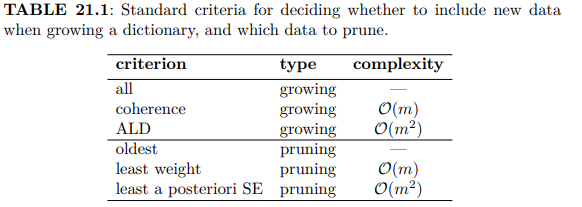

Podemos verificar se um dado de entrada é suficientemente significativo utilizando-se do critério de coerência.

**DEFINIÇÃO (CRITÉRIO DE COERÊNCIA):** Dado $D$ um dicionário. Seja a iteração atual como i e considere o dado recém chegado como x. Logo, a coerência de x será dada por:

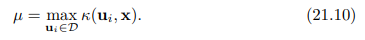

Logo, $x$ entrará em $D$ se, e somente se $\mu \leq \mu_0$, onde $\mu_0$ é um valor pré-estabelecido.

O cientista deve se atentar com valores de $\mu_0$, pois para valores grandes determina que mais dados entrarão no dicionário $D$ enquanto que para valores pequenos significa que poucos dados de entrada entrarão em $D$.

Note que esse método tem um custo computacional razoável, pois deve-se realizar $m$ calculos de funções kernel.

Um critério mais sofisticado que o anterior é quando verificamos o quão aproximado o dado recém chegado $x$ no espaço de recursos como uma combinação linear das bases de $D$. Esse critério verifica-rá se a condição de dependência linear aproximada (ALD) é válida, dada por:

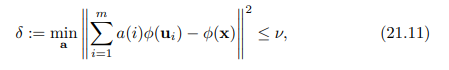

Onde $\nu$ é o limite de precisão.

Note que quanto menor for o valor de $\nu$ mais dados serão aceitos e adicionados em $D$.

### 2.4 Métodos de Regressão de mínimos quadrados recursivos de Kernel (KRLS)

Nesta seção, abordaremos a atualização recursiva  para a solução que vimos anteriormente em (KRR) e que é conhecida como (KRLS).

Essa estratégia envolve uma solução a qual todos os dados de treinamento aparecem na solução final. Quando introduzimos estratégias de dicionário obtemos diversos algoritmos práticos que limitam o crescimento da nossa solução.

#### 2.4.1 Atualização recursiva de 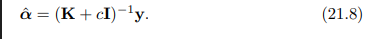

Suponha que tenhamos $n-1$ dados aprendidos em nosso modelo, na (n-1)-ésima iteração, a solução da equação (21.8) vai nos retornar:

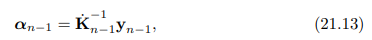

Onde, $\dot{K} = K + c\mathbb{I}$ é a matriz de Kernel regularizada.

Agora, quando estivermos na iteração $n$, um par $(x_n,y_n)$ é recebido e desejamos atualizar nossa função (21.13) recursivamente. Mas antes, devemos calcular a nossa previsão que será dada por:

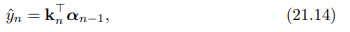

Onde, $k_n = [k(x_n,x_1), ..., k(x_n,x_{n-1})]$

A qual terá um erro associado: $e_n = y_n - \hat{y_n}$

Logo, a matriz do Kernel atualizada será:

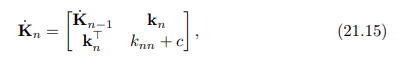

Onde $k_{nn} = k(x_n,x_n)$

Agora, vamos introduzir as variáveis $a_n$ e $\gamma_n$ a qualsão dadas por:

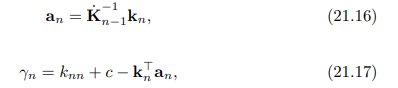

Vamos obter assim que, a nossa matriz inversa de Kernel será dada por:

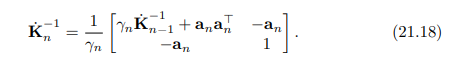

Onde finalmente obtemos a nossa solução atualizada:

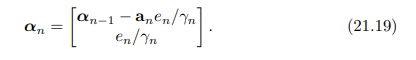

**Nota:** As funções (21.18) e (21.19) podem ser calculadadas em tempo $O(n^2)$.

#### 2.4.2 Algoritmo KRLS de dependência linear aproximada

Utilizaremos o critério ALD que foi descrito na seção de Dicionário (Último critério), a qual o ALD tem complexidade de $O(m^2)$.

Nosso algoritmo é dado por:

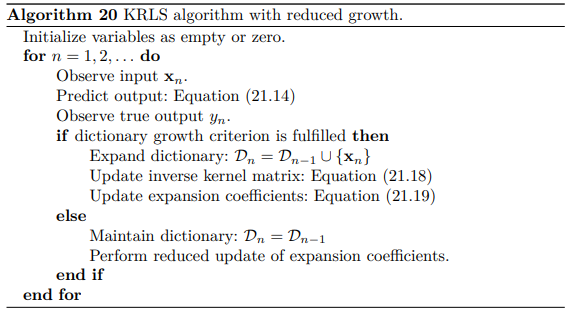

In [8]:
class KRLS:
    def __init__(self, kernel_type='rbf', sigma=1.0, c=1.0, nu=1e-6):
        """
        Inicializa o modelo KRLS.
        
        :param kernel_type: Tipo de kernel a ser utilizado ('rbf' ou 'linear')
        :param sigma: Parâmetro do kernel RBF
        :param c: Parâmetro de regularização
        :param nu: Critério de crescimento
        """
        self.kernel_type = kernel_type  # Tipo de kernel ('rbf' ou 'linear')
        self.sigma = sigma  # Parâmetro do kernel RBF
        self.c = c          # Parâmetro de regularização
        self.nu = nu        # Critério de crescimento
        self.D = []         # Dicionário de vetores de suporte
        self.alpha = []     # Coeficientes de expansão
        self.K_inv = None   # Inversa da matriz de kernel regularizada
    def __rbf_kernel(self, x1, x2):
        """
        Calcula o kernel RBF entre dois vetores (função privada).
        """
        return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * self.sigma ** 2))
    
    def __linear_kernel(self, x1, x2):
        """
        Calcula o kernel linear entre dois vetores (função privada).
        """
        return np.dot(x1,x2)
    
    def __kernel(self, x1, x2):
        """
        Escolhe o kernel de acordo com o tipo especificado ('rbf' ou 'linear').
        """
        if self.kernel_type == 'rbf':
            return self.__rbf_kernel(x1, x2)
        elif self.kernel_type == 'linear':
            return self.__linear_kernel(x1, x2)
        else:
            raise ValueError("Tipo de kernel não suportado. Escolha 'rbf' ou 'linear'.")

    def predict(self, x):
        """
        Prediz o valor da saída para uma nova amostra x, usando o dicionário atual e os coeficientes.
        """
        if not self.D:  # Se o dicionário estiver vazio
            return 0
        
        k_n = np.array([self.__kernel(x, u) for u in self.D])
        return np.dot(k_n.T, self.alpha)  # Retorna um escalar

    def __compute_an(self, k_n):
        """
        Calcula o vetor intermediário a_n (função privada).
        """
        return np.dot(self.K_inv, k_n)

    def __compute_gamma_n(self, k_nn, k_n, a_n):
        """
        Calcula o valor escalar gamma_n (função privada).
        """
        return k_nn + self.c - np.dot(k_n.T, a_n)

    def __update_kernel_inverse(self, a_n, gamma_n):
        """
        Atualiza a inversa da matriz de kernel quando o dicionário é expandido (função privada).
        """
        K_inv_old = self.K_inv
        K_inv_new = np.zeros((len(self.D), len(self.D)))
        if K_inv_old is not None:
            K_inv_new[:-1, :-1] = K_inv_old + np.outer(a_n, a_n) / gamma_n
            K_inv_new[:-1, -1] = -a_n / gamma_n
            K_inv_new[-1, :-1] = -a_n.T / gamma_n
            K_inv_new[-1, -1] = 1 / gamma_n
        else:
            K_inv_new[0, 0] = 1 / (self.__kernel(self.D[0], self.D[0]) + self.c)
        return K_inv_new

    def __update_alpha(self, e_n, gamma_n, a_n):
        """
        Atualiza os coeficientes de expansão alpha (função privada).
        """
        self.alpha = np.append(self.alpha, 0)
        self.alpha += (e_n / gamma_n) * np.append(-a_n, 1)

    def learn_one(self, x_n, y_n):
        """
        Atualiza o modelo KRLS com a nova amostra (x_n, y_n).
        """
        if not self.D:
            # Inicializa o dicionário e a matriz K_inv
            self.D.append(x_n)
            self.K_inv = np.array([[1 / (self.__kernel(x_n, x_n) + self.c)]])
            self.alpha = np.array([y_n])
            return

        # Predição
        y_hat = self.predict(x_n)

        # Cálculo do erro
        e_n = y_n - y_hat

        # Vetor de kernel k_n
        k_n = np.array([self.__kernel(x_n, u) for u in self.D])

        # Similaridade com o próprio ponto
        k_nn = self.__kernel(x_n, x_n)

        # Cálculo de a_n
        a_n = self.__compute_an(k_n)

        # Cálculo de gamma_n
        gamma_n = self.__compute_gamma_n(k_nn, k_n, a_n)

        # Critério de crescimento do dicionário
        if np.all(gamma_n > self.nu):
            # Expandir o dicionário
            self.D.append(x_n)

            # Atualizar a matriz inversa de kernel
            self.K_inv = self.__update_kernel_inverse(a_n, gamma_n)

            # Atualizar os coeficientes de expansão alpha
            self.__update_alpha(e_n, gamma_n, a_n)
        else:
            # Atualizar o dicionário sem expansão
            self.alpha += (e_n / gamma_n) * a_n

In [9]:
from sklearn.preprocessing import StandardScaler

x_scale = StandardScaler()
y_scale = StandardScaler()

X_train_scaled = x_scale.fit_transform(X_train)
X_test_scaled = x_scale.fit_transform(X_test)

y_train_scaled = y_scale.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scale.fit_transform(y_test.values.reshape(-1, 1))

In [10]:
model = KRLS(kernel_type='rbf', sigma=2.5, c=5, nu=1e-2)

In [11]:
previsao = []
for i in range(len(X_train_scaled)):
    y_pred = model.predict(X_train_scaled[i])
    previsao.append(y_pred)
    model.learn_one(y_pred, y_train_scaled[i][0])

In [12]:
y_pred_original = y_scale.inverse_transform(np.array([previsao]))

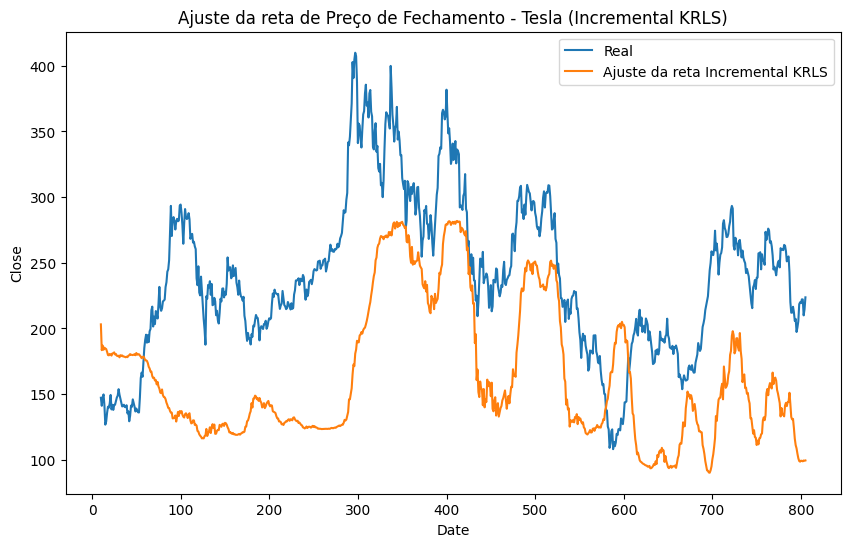

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(X_train.index, y_train, label='Real')
plt.plot(X_train.index, y_pred_original[0], label='Ajuste da reta Incremental KRLS')
plt.title('Ajuste da reta de Preço de Fechamento - Tesla (Incremental KRLS)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [14]:
one_step_ahead = model.predict(X_test_scaled[0])

In [15]:
one_step_ahead = y_scale.inverse_transform(np.array([[one_step_ahead]]))

In [16]:
print(f'Valor previsto: {one_step_ahead[0][0]}')
print(f'Valor verdadeiro: {y_test.iloc[0]}')

Valor previsto: 161.45876498027755
Valor verdadeiro: 237.41000366210935


In [17]:
multi_step_ahead = []

for i in range(len(X_test_scaled)):
    y_pred = model.predict(X_test_scaled[i])
    multi_step_ahead.append(y_pred)
    model.learn_one(y_pred, y_test_scaled[i][0])

In [18]:
multi_step_ahead = y_scale.inverse_transform(np.array([multi_step_ahead]))

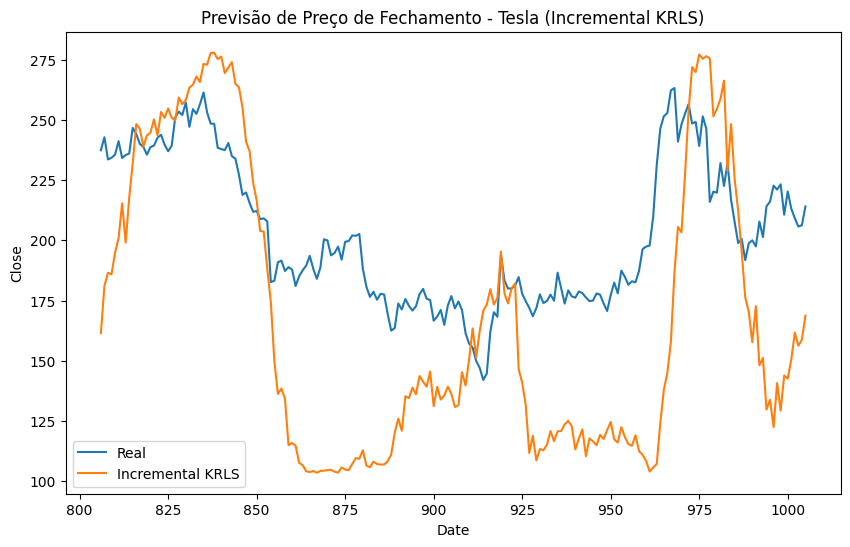

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, multi_step_ahead[0], label='Incremental KRLS')
plt.title('Previsão de Preço de Fechamento - Tesla (Incremental KRLS)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [20]:
calcular_metricas_regressao(y_test, pd.DataFrame(multi_step_ahead[[0]]))

,Métrica,Valor
0,MAE,45.918125
1,MSE,2979.376638
2,MAPE,23.341965
3,RMSE,54.583666
4,R²,-2.260045
5,THEIL,60.679635
6,ARV,3.260045
7,WPOCID,0.507538


As funções kernels mais utilizadas nos modelos das bibliotecas são os descritos a baixo:

**Kernel Linear:** Este kernel é a simples multiplicação escalar dos vetores de entrada. A fórmula é dada por: 

$K(x_i, x_j) = x_i^T x_j$

**Kernel RBF (Radial Basis Function):** O kernel RBF mede a similaridade entre os pontos com base na distância euclidiana. A fórmula é:

$K(x_i, x_j) = e^{-\frac{\|x_i - x_j\|^2}{2\sigma^2}}$

**Kernel Polinomial:** Este kernel eleva a soma do produto escalar a uma potência, permitindo a modelagem de relações não lineares. A fórmula é:

$K(x_i, x_j) = (x_i^T x_j + c)^d$

**Kernel Sigmoide:** Este kernel é baseado na função tangente hiperbólica e é útil em redes neurais. A fórmula é:

$K(x_i, x_j) = \tanh(\alpha x_i^T x_j + c)$

**Kernel Exponencial:** Esse kernel mede a similaridade com base na distância, semelhante ao RBF, mas sem o quadrado. A fórmula é:

$K(x_i, x_j) = e^{-\beta \|x_i - x_j\|}$


#### 2.4.3 Algoritmo KRLS-T (KRLS Tracker Algorithm)

Nesta seção, abordaremos o algoritmo conhecido na literatura como **KRLS-T** que lida com a incerteza sobre os dados, como base na estrutura bayesiana.

Esse algoritmo inclui um mecanismo de esquecimento que permite lidar com cenários não-estacionários. Com dados não-estacionários, os algoritmos de Aprendizado Onoine são capazes de rastrear mudanças no modelo que é observado.

O algortimo que será propsoto se concentrará na estratégia de esquecimento que é chamada de **BACK TO THE PRIOR (B2P)**, a qual:

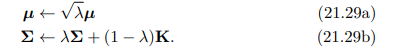

Em outras palavras, o **BACK TO THE PRIOR (B2P)** faz com que quando damos um passo atrás na direção ao conhecimento a prior. O $\lambda$ nas equações anterior é o nosso fator de eescimento.


O algoritmo proposto é dado por:


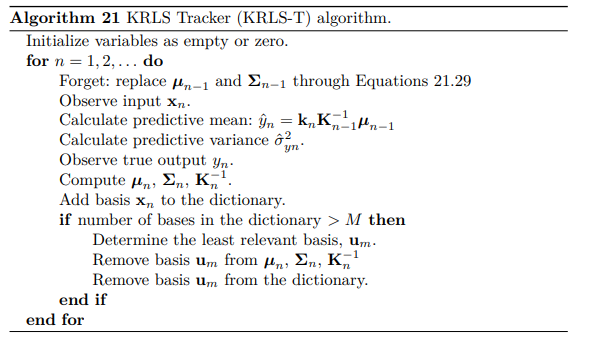


Em outras literaturas podem ser encontardas versões desse algoritmo diferentes como, o proposto por Steven Van Vaerenbergh. Link: https://www.squobble.com/academic/krlst/node12.html

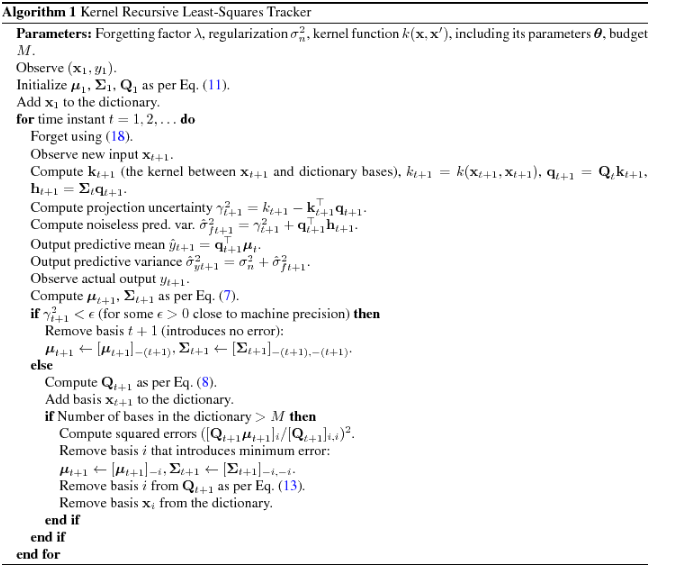

O algortimo consta como implementado no github e disponibilizado publicamente pelo link: https://github.com/lckr/PyKRLST/blob/master/pyKRLST/KRLST.py. A implementação do mesmo se baseia no pseudocódigo proposto por Steven Van Vaerenbergh.

In [21]:
""" Kernel Recursive Least-Squares Tracker Algorithm

    References: 
        M. Lazaro-Gredilla, S. Van Vaerenbergh and I. Santamaria, "A Bayesian
        approach to tracking with kernel recursive least-squares", 2011 IEEE
        Workshop on Machine Learning for Signal Processing (MLSP 2011),
        Beijing, China, September 2011.
        S. Van Vaerenbergh, M. Lazaro-Gredilla, and I. Santamaria, ‘Kernel 
        Recursive Least-Squares Tracker for Time-Varying Regression’, IEEE Trans.
        Neural Netw. Learning Syst., vol. 23, no. 8, pp. 1313–1326, Aug. 2012,
        doi: 10.1109/TNNLS.2012.2200500.

"""


# Authors: Lucas Krauß <lucas.krauss@pm.me>
#
# License: MIT

import numpy as np
import warnings
from typing import Tuple
from sklearn.gaussian_process.kernels import Kernel


class KRLST:
    """Kernel Recursive Least-Squares Tracker Algorithm

    Maintains a fixed budget via growing and pruning and regularization.
    Assumes a fixed value for the lengthscale, the regularization factor and the signal and
    noise powers.
    """

    def __init__(
        self, kernel: Kernel, l: float, c: float, M: int, forgetmode: str = "B2P", jitter=1e-10
    ):
        """
        Args:
            kernel (Kernel): Kernel object
            l (float): Forgetting factor. l \in [0,1]
            c (float): Noise-to-signal ratio (regularization)
            M (int): Budget, i.e., maximum size of dictionary
            forgetmode (str): Either back-to-prior ('B2P') or uncertainty injection ('UI')
        """
        self._kernel = kernel

        if l < 0 or l > 1:
            raise ValueError("Parameter `l` is out of allowed range of [0,1].")
        self._lambda = l

        self._c = c
        self._M = M

        if not (forgetmode in ["B2P", "UI"]):
            raise ValueError("Parameter `forgetmode` can either be 'B2P' or 'UI'.")
        self._forgetmode = forgetmode

        self._jitter = jitter
        self._is_init = False

    def fit(self, X: np.ndarray, Y: np.ndarray, T: np.ndarray):
        """Observes a single data point and label and updates model with this new observations.
        The update procedure includes forgetting of past information, adding new basis elements
        and reducing the size of the basis if its size becomes larger as the specified `M`.

        Args:
            X (np.ndarray): Array of data points with shape (n_data_points, n_features). Can be
                of any type.
            Y (np.ndarray): Float array of labels with shape (n_data_points,). Does not support
                multilabels.
            T (np.ndarray): Int array of time indices with shape (n_data_points,).
        """
        for x, y, t in zip(X, Y, T):
            self.observe(x, y, t)
        return self

    def observe(self, x: np.ndarray, y: float, t: int):
        """Observes a single data point and label and updates model with this new observations.
        The update procedure includes forgetting of past information, adding new basis elements
        and reducing the size of the basis if its size becomes larger as the specified `M`.

        Args:
            x (np.ndarray): Single data point with shape (1, n_features). Can be of any type
            y (float): Single regression target
            t (int): time index
        """
        if not self._is_init:  # Initialize model

            kss = self._kernel(x) + self._jitter
            self.Q = 1 / kss
            self.mu = (y * kss) / (kss + self._c)
            self.Sigma = kss - ((kss ** 2) / (kss + self._c))  # Check this

            self.basis = 0  # Dictionary indicies
            self.Xb = x  # Dictionary
            self.m = 1  # Dict size

            self.nums02ML = y ** 2 / (kss + self._c)
            self.dens02ML = 1
            self.s02 = self.nums02ML / self.dens02ML

            self._is_init = True

        else:  # Update model

            if self._lambda < 1:
                # Forgetting

                if self._forgetmode == "B2P":  # Back-to-prior
                    Kt = self._kernel(self.Xb)
                    self.Sigma = self._lambda * self.Sigma + (1 - self._lambda) * Kt
                    self.mu = np.sqrt(self._lambda) * self.mu

                elif self._forgetmode == "UI":  # Uncertainty injection
                    self.Sigma = self.Sigma / self._lambda
                else:
                    raise ValueError(
                        "Undefined forgetting strategy.\nSupported forgetting strategies"
                        + "are 'B2P' and 'UI'."
                    )

            # Predict new sample
            kbs = self._kernel(self.Xb, np.atleast_2d(x))
            kss = self._kernel(x) + self._jitter

            q = self.Q @ kbs
            ymean = q.T @ self.mu
            gamma2 = kss - kbs.T @ q
            gamma2[gamma2 < 0] = 0

            h = self.Sigma @ q
            sf2 = gamma2 + q.T @ h
            sf2[sf2 < 0] = 0

            sy2 = self._c + sf2

            # Include new sample and add new basis
            Q_old = self.Q.copy()
            p = np.block([[q], [-1]])
            self.Q = np.block(
                [[self.Q, np.zeros((self.m, 1))], [np.zeros((1, self.m)), 0]]
            ) + (1 / gamma2) * (p @ p.T)

            p = np.block([[h], [sf2]])
            self.mu = np.block([[self.mu], [ymean]]) + ((y - ymean) / sy2) * p
            self.Sigma = np.block([[self.Sigma, h], [h.T, sf2]]) - (1 / sy2) * (p @ p.T)
            self.basis = np.block([[self.basis], [t]])
            self.m = self.m + 1
            self.Xb = np.block([[self.Xb], [x]])

            # Estimate s02 via maximum likelihood
            self.nums02ML = self.nums02ML + self._lambda * (y - ymean) ** 2 / sy2
            self.dens02ML = self.dens02ML + self._lambda
            self.s02 = self.nums02ML / self.dens02ML

            # Remove basis if necessary
            if (self.m > self._M) or (gamma2 < self._jitter):

                if gamma2 < self._jitter:
                    if gamma2 < self._jitter / 10:
                        warnings.warn(
                            "Numerical roundoff error is too high. Try increasing jitter noise."
                        )
                    criterium = np.block([np.ones((self.m - 1)), 0])
                else:  # MSE pruning
                    errors = (self.Q @ self.mu).reshape(-1) / np.diag(self.Q)
                    criterium = np.abs(errors)

                r = np.argmin(criterium)
                smaller = criterium > criterium[r]

                if r == self.m:  # remove the element we just added
                    self.Q = Q_old
                else:
                    Qs = self.Q[smaller, r]
                    qs = self.Q[r, r]
                    self.Q = self.Q[smaller][:, smaller]
                    self.Q = self.Q - (Qs.reshape(-1, 1) * Qs.reshape(1, -1)) / qs

                self.mu = self.mu[smaller]
                self.Sigma = self.Sigma[smaller][:, smaller]
                self.basis = self.basis[smaller]
                self.m = self.m - 1
                self.Xb = self.Xb[smaller, :]

    def predict(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Predicts mean and variance for potentially unseen data X

        Args:
            X (np.ndarray): Array of data points with shape (n_data_points, n_features)

        Returns:
            mean_est (np.ndarray), var_est (np.ndarray): Predicted mean and variance
        """
        kbs = self._kernel(self.Xb, np.atleast_2d(X))
        mean_est = kbs.T @ self.Q @ self.mu
        sf2 = (
            1
            + self._jitter
            + np.sum(
                kbs * ((self.Q @ self.Sigma @ self.Q - self.Q) @ kbs), axis=0
            ).reshape(-1, 1)
        )
        sf2[sf2 < 0] = 0
        var_est = self.s02 * (self._c + sf2)

        return mean_est, var_est

In [22]:
from sklearn.gaussian_process.kernels import RBF

In [23]:
kernel = RBF(1)
model_krlst = KRLST(kernel=kernel, l=0.00001,c=0.00001,M=30,forgetmode='B2P')

In [24]:
for i in range(len(X_train_scaled)):
    model_krlst.observe(X_train_scaled[i], y_train_scaled[i], int(X_train.index[i]))

In [25]:
previsoes_krls_t = []
desvios = []
for i in range(len(X_test_scaled)):
    y_pred, desv = model_krlst.predict(X_test_scaled[i])
    model_krlst.observe(X_test_scaled[i], y_test_scaled[i], int(X_test.index[i]))
    previsoes_krls_t.append(y_pred)
    desvios.append(desv)

In [26]:
flattened_values = [arr[0, 0] for arr in previsoes_krls_t]

In [27]:
previsao = y_scale.inverse_transform(np.array([flattened_values]))

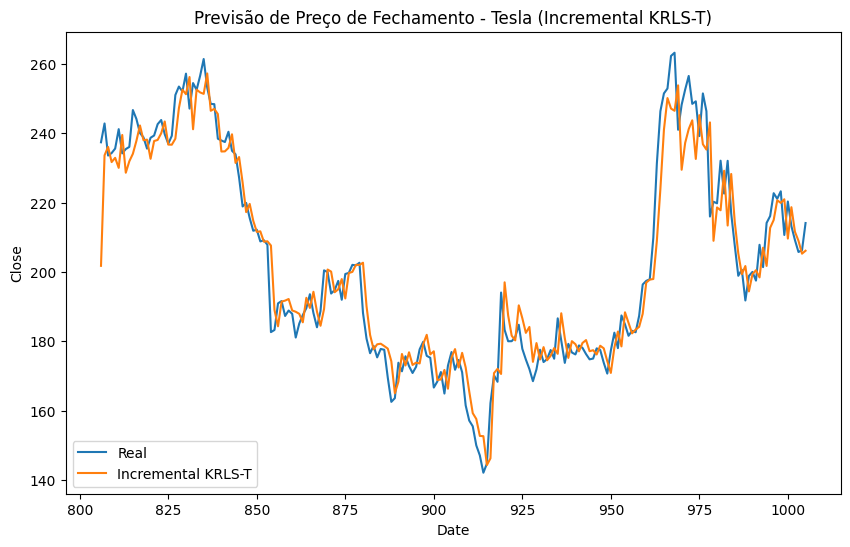

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, previsao[0], label='Incremental KRLS-T')
plt.title('Previsão de Preço de Fechamento - Tesla (Incremental KRLS-T)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [29]:
calcular_metricas_regressao(y_test, pd.DataFrame(previsao[0]))

,Métrica,Valor
0,MAE,6.008711
1,MSE,66.807451
2,MAPE,2.934900
3,RMSE,8.173582
4,R²,0.926899
5,THEIL,1.243252
6,ARV,0.073101
7,WPOCID,0.567839


**OBSERVAÇÕES:**


As funções baseadas em kernel online são uma área ativa de pesquisa, e além do Kernel Recursive Least Squares (KRLS) e do Kernel Recursive Least Squares with Time (KRLST), existem outros algoritmos e abordagens. Aqui estão alguns exemplos:

**- Kernel Adaptive Filtering (KAF):** Essa abordagem utiliza métodos adaptativos baseados em kernel para resolver problemas de filtragem, como previsão de séries temporais.

**- Kernel Least Mean Squares (KLMS):** Uma variação do algoritmo LMS (Least Mean Squares) que utiliza funções de kernel para adaptar-se a dados de maneira não linear.

**- Support Vector Regression (SVR) com Aprendizado Online:** O SVR pode ser adaptado para um cenário online, onde o modelo é atualizado continuamente com novos dados.

**- Gaussian Processes (GP):** Embora não seja um algoritmo "online" por definição, os processos gaussianos podem ser usados para modelagem de funções com incertezas e podem ser adaptados para lidar com dados em streaming.